# Importing Dependencies



In [11]:
import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC

## Importing Dataset

In [12]:
dataset_columns = ["sentiment" , "id" , "time" , "flag" , "user" , "text" ]
dataset_coding = "ISO-8859-1"
dataset = pd.read_csv("training.1600000.processed.noemoticon.csv", names = dataset_columns , encoding = dataset_coding )

In [13]:
dataset.head()

,sentiment,id,time,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [14]:
print("Dataset size:", len(dataset))

Dataset size: 1600000


In [15]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   id         1600000 non-null  int64 
 2   time       1600000 non-null  object
 3   flag       1600000 non-null  object
 4   user       1600000 non-null  object
 5   text       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [16]:
dataset["sentiment"].unique()

array([0, 4])

In [17]:
dataset["sentiment"].nunique()

2

In [18]:
dataset["sentiment"].value_counts()

4    800000
0    800000
Name: sentiment, dtype: int64

In [19]:
dataset.isnull().sum()

sentiment    0
id           0
time         0
flag         0
user         0
text         0
dtype: int64

## Preprocessing / Cleaning Text

In [20]:
nltk.download('stopwords')
all_stopwords = stopwords.words('english')


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/astha_kushwaha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
def preprocess(tweet , stem = True):
    processedText = []
    
    urlPattern =  r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern = '@[^\s]+'
    alphanumericPattern = r'\w*\d\w*'
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    punc = r'[^\w\s]'
    
    tweet = tweet.lower()
    tweet = re.sub(urlPattern , '' , tweet)
    tweet = re.sub(userPattern , '' , tweet)
    tweet = re.sub(alphanumericPattern , '' , tweet)
    tweet = re.sub(sequencePattern , seqReplacePattern , tweet)
    tweet = re.sub(punc,"",tweet)
    
    tweet = tweet.split()   
    ps = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    
    all_stopwords = stopwords.words('english')
  
    
    for word in tweet:
            if word not in (all_stopwords):
                if stem:
                    processedText.append(ps.stem(word))
                else:
                    processedText.append(word)
    processedText = [lemmatizer.lemmatize(w, pos='a') for w in processedText]
                
    return " ".join(processedText)
    
        
   

      

In [22]:
cleared_dataset = dataset.sample(frac=1).reset_index(drop=True)
cleared_dataset = cleared_dataset.iloc[0:]
cleared_dataset.info()
cleared_dataset["sentiment"].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   id         1600000 non-null  int64 
 2   time       1600000 non-null  object
 3   flag       1600000 non-null  object
 4   user       1600000 non-null  object
 5   text       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


4    800000
0    800000
Name: sentiment, dtype: int64

In [23]:
import time
start_time = time.time()
#cleared_dataset = cleared_dataset.drop(cleared_dataset.index[0]).reset_index()
cleared_dataset = cleared_dataset.drop(['time','flag','user','id'],axis=1)
cleared_dataset["cleared_text"] = cleared_dataset["text"].apply(preprocess)
print("--- %s seconds ---" % (time.time() - start_time))
X = cleared_dataset['cleared_text']
print(X)

--- 475.9277198314667 seconds ---
0                                 hope good news embargo sad
1                                                earli studi
2          got back absolut factori big cut leg ear broth...
3          amber hous listen sing actual pretti good sing...
4          cant seem find fake jo whiley twitter start ch...
                                 ...                        
1599995                         ive ditch feel go happen lot
1599996    im outta tweepstri figur weekend good one peop...
1599997            keep retweet theyv got get back might cri
1599998    acryl nail drive small suv get keep street cre...
1599999               lebron jame cav win im still paper tho
Name: cleared_text, Length: 1600000, dtype: object


In [24]:
cleared_dataset

,sentiment,text,cleared_text
0,0,@LFCTV and there was me hoping for good news a...,hope good news embargo sad
1,4,Up early 2 study then off to my 9 to 5,earli studi
2,4,just got back from the absolut factory.. have...,got back absolut factori big cut leg ear broth...
3,0,at ambers house. listening to her sing. actua...,amber hous listen sing actual pretti good sing...
4,0,Can't seem to find 'The Fake Jo Whiley' Twitte...,cant seem find fake jo whiley twitter start ch...
...,...,...,...
1599995,0,I've been ditched... I have a feeling this is ...,ive ditch feel go happen lot
1599996,4,I'm outta here tweeps...trying to figure out w...,im outta tweepstri figur weekend good one peop...
1599997,0,@shaunarawrr_x We should keep re-tweeting this...,keep retweet theyv got get back might cri
1599998,0,@phloxy I have acrylic nails and drive a (smal...,acryl nail drive small suv get keep street cre...


## Analysing Data

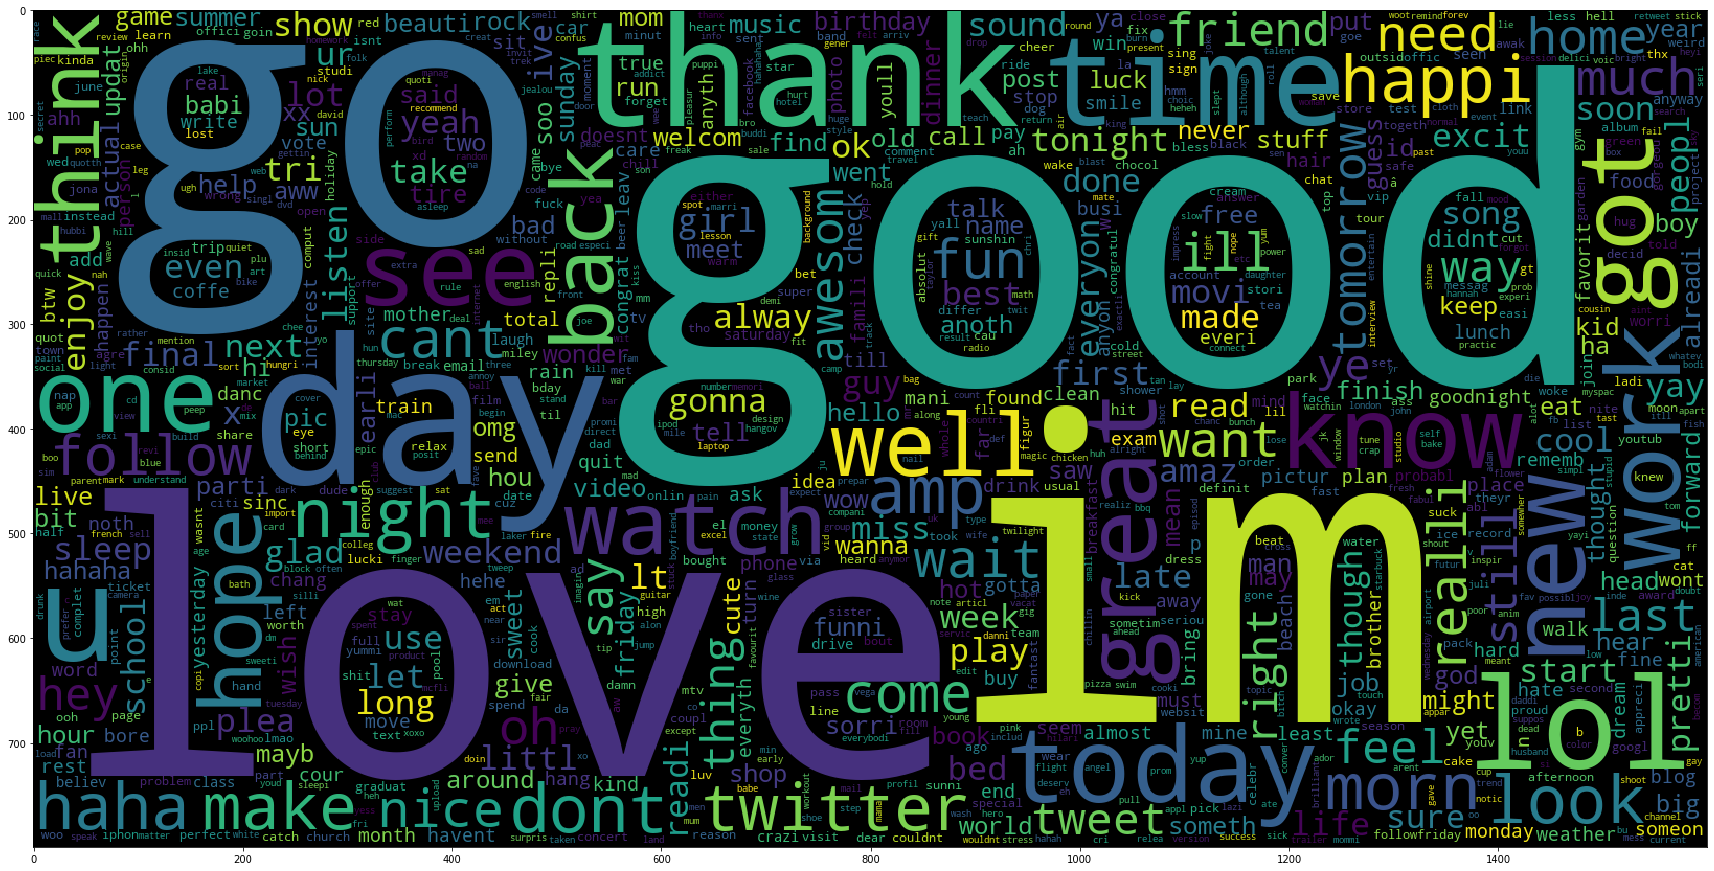

In [25]:
positive_tweet = cleared_dataset["cleared_text"][cleared_dataset["sentiment"]==4]
plt.figure(figsize = (30,30))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(",".join(map(str, positive_tweet)))
plt.imshow(wc)

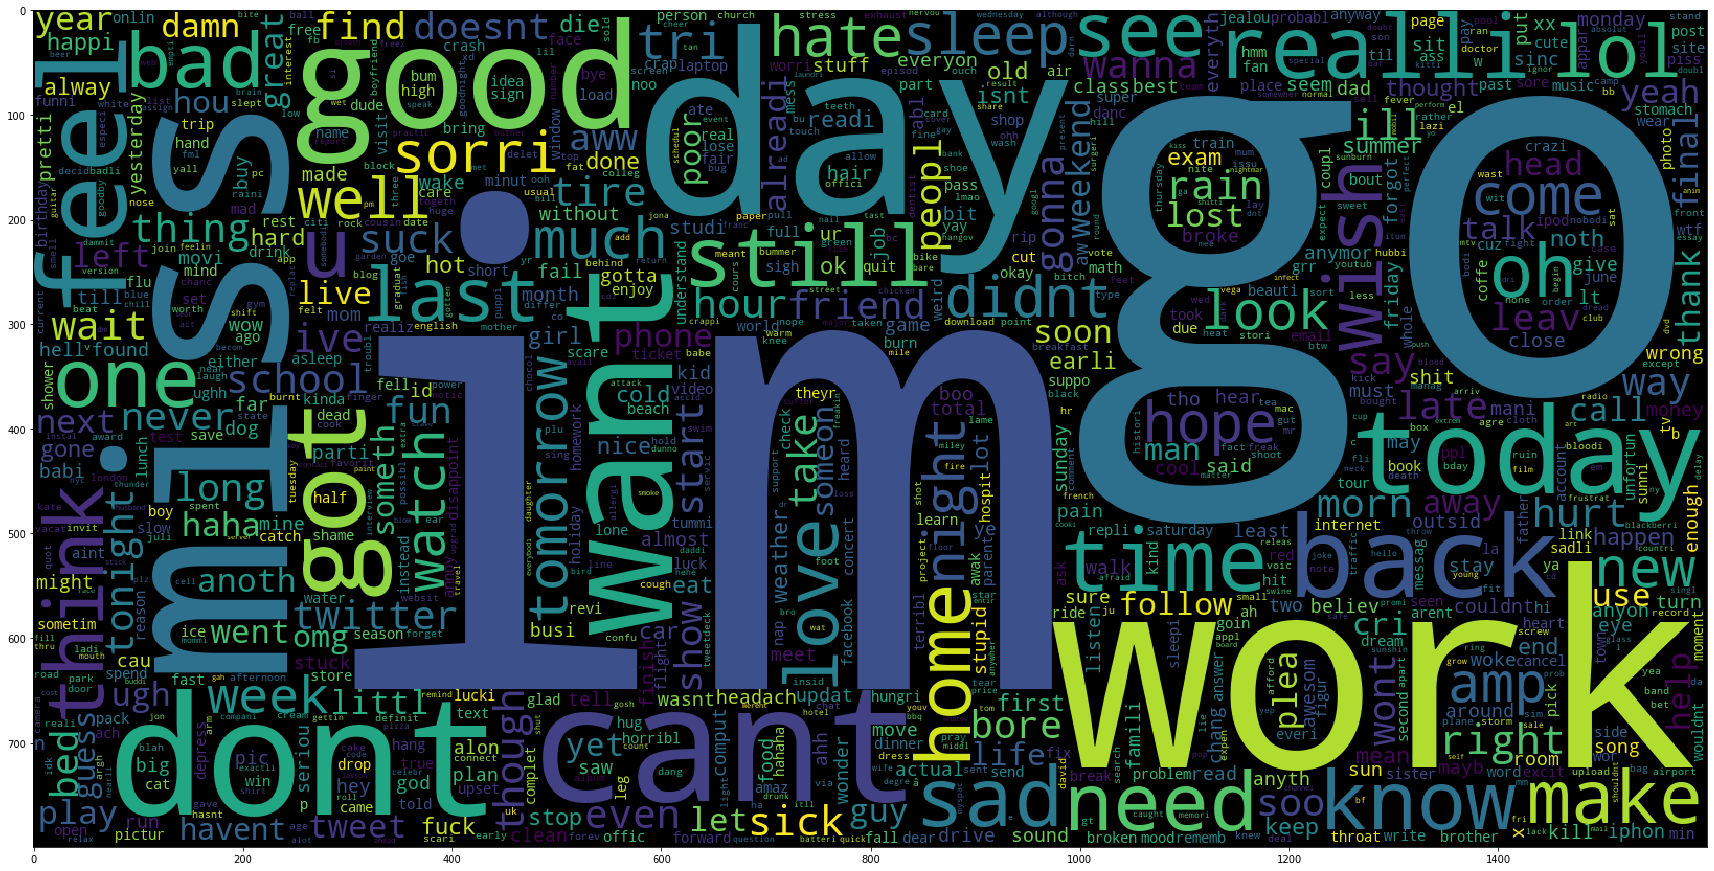

In [26]:
negative_tweet = cleared_dataset["cleared_text"][cleared_dataset["sentiment"]==0]
plt.figure(figsize = (30,30))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(",".join(map(str, negative_tweet)))
plt.imshow(wc)

## Splitting Dataset

In [35]:
y = cleared_dataset['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size = 0.30, random_state = 10)

## TF - IDF Vectorizer

In [36]:
vectorizer = TfidfVectorizer(analyzer='word',max_df=0.90, min_df=2, max_features = 500000,ngram_range=(1,2))
X_train = vectorizer.fit_transform(X_train)
tfidf_tokens = vectorizer.get_feature_names()
print("Number of feature_words = ", len(tfidf_tokens))
print(tfidf_tokens[1:2000])



Number of feature_words =  500000
['__ __', '__ bed', '__ dont', '__ exam', '__ feel', '__ fill', '__ friend', '__ fuck', '__ get', '__ gonna', '__ hope', '__ ill', '__ im', '__ like', '__ look', '__ love', '__ miss', '__ nice', '__ oh', '__ shit', '__ suck', '__ take', '__ thank', '__ well', '__ wish', '__d', '__i', '__lt', '__quot', '__x', '_and', '_bam_', '_do_', '_i', '_i_', '_is_', '_love_', '_lt', '_more_', '_must_', '_myanalt', '_not_', '_quot', '_quot work', '_really_', '_that_', '_the', '_those_', '_very_', '_was_', '_whi', '_why_', '_will_', '_you_', '_z', '_zz', 'a__', 'a_list', 'aa', 'aa amp', 'aa batteri', 'aa belli', 'aa book', 'aa cannot', 'aa cant', 'aa come', 'aa dad', 'aa doesnt', 'aa dont', 'aa get', 'aa good', 'aa hate', 'aa hoodi', 'aa idea', 'aa im', 'aa lot', 'aa love', 'aa man', 'aa mau', 'aa meet', 'aa miss', 'aa monday', 'aa need', 'aa new', 'aa number', 'aa rescu', 'aa see', 'aa wanna', 'aa want', 'aa work', 'aa your', 'aaaaaaalcohol', 'aabt', 'aac', 'aach', 

In [38]:
X_test  = vectorizer.transform(X_test)

## Scaling

In [39]:
x_max = X_train.max()
x_min = X_train.min()

X_train = (X_train - x_min)/x_max
X_test = (X_test - x_min)/x_max


## Model Evaluation

In [40]:

def model(model):
    y_pred = model.predict(X_test)
    y_pred = pd.Series(y_pred)
    y_pred = y_pred.values 
    y_test_ = pd.Series(y_test) 
    y_test_ = y_test_.values 
    #print("Comparison:")
    #result = np.concatenate((y_pred.reshape(len(y_pred),1), y_test_.reshape(len(y_test_),1)),1)
    #print(result[1:500])
    
    c_matrix = confusion_matrix(y_test_, y_pred)
    print("Confusion Matrix = \n",c_matrix)
    print("Accuracy Score = ",accuracy_score(y_test_, y_pred))
    print("Train Score = ",model.score(X_train, y_train))
    print("Test Score = ",model.score(X_test, y_test))
    
    
    
    categories = ['Negative','Positive']
    prediction = ['True Negative','False Positive', 'False Negative','True Positive']
    percentage = ['{0:.2%}'.format(value) for value in c_matrix.flatten() / np.sum(c_matrix)]

    labels = [f'{m}\n{n}' for m, n in zip(prediction,percentage)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(c_matrix,cmap = 'Blues' , fmt = '',annot = labels, xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values")
    plt.ylabel("Actual values")
    plt.title ("Confusion Matrix")
    
    

## Logistic Regression

Confusion Matrix = 
 [[187530  52205]
 [ 45830 194435]]
Accuracy Score =  0.7957604166666666
Train Score =  0.8557973214285715
Test Score =  0.7957604166666666
--- 39.61894369125366 seconds ---


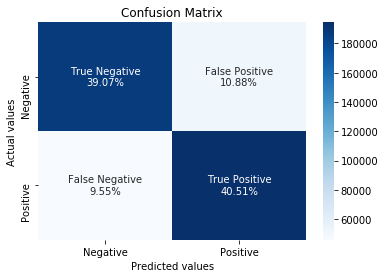

In [41]:
import time
start_time = time.time()
logistic_reg = LogisticRegression(solver = 'sag',C = 2, max_iter = 1500)
logistic_reg.fit(X_train, y_train) 
model(logistic_reg)
print("--- %s seconds ---" % (time.time() - start_time))

## Bernoulli Naive Bayes 

Confusion Matrix = 
 [[180041  59694]
 [ 46358 193907]]
Accuracy Score =  0.7790583333333333
Train Score =  0.8284633928571429
Test Score =  0.7790583333333333
--- 1.917257308959961 seconds ---


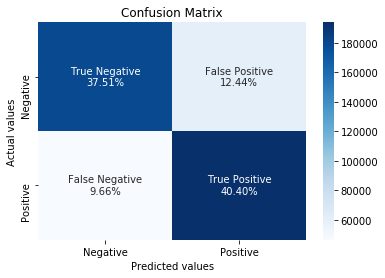

In [42]:
start_time = time.time()
naive_bayes = BernoulliNB()
naive_bayes.fit(X_train, y_train) 
model(naive_bayes)
print("--- %s seconds ---" % (time.time() - start_time))

## Support Vector Machine

Confusion Matrix = 
 [[184258  55477]
 [ 49770 190495]]
Accuracy Score =  0.7807354166666667
Train Score =  0.9006857142857143
Test Score =  0.7807354166666667
--- 26.731040239334106 seconds ---


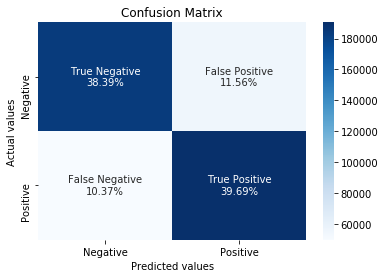

In [43]:
start_time = time.time()
svm_model = LinearSVC()
svm_model.fit(X_train, y_train) 
model(svm_model)
print("--- %s seconds ---" % (time.time() - start_time))

In [44]:
def predict_text(model,text):
    textdata = vectorizer.transform([preprocess(text)])
    sentiment = model.predict(textdata)
    
         
    df = pd.DataFrame(columns = ['text','sentiment'])
    df['text'] = text
    df['sentiment'] = sentiment
    df = df.replace([0,4], ["Negative","Positive"])
    return df

    

In [45]:
if __name__=="__main__":
    text = "bd nit"
    df = predict_text(svm_model, text)
    print(df)

   text sentiment
0   NaN  Negative
